In [3]:
pip install dateparser

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.8/293.8 kB 5.6 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import numpy as np
import dateparser
import pytz
import warnings
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [5]:
#просмотрим общую информацию о датафрейме
train = pd.read_csv('/kaggle/input/second-market-auto/train.csv')
test = pd.read_csv('/kaggle/input/second-market-auto/test.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 50.4+ MB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          110058 non-null  int64  
 1   make          107997 non-null  object 
 2   model         107979 non-null  object 
 3   trim          107944 non-null  object 
 4   body          107464 non-null  object 
 5   transmission  97047 non-null   object 
 6   vin           110058 non-null  object 
 7   state         110058 non-null  object 
 8   condition     107679 non-null  float64
 9   odometer      110039 non-null  float64
 10  color         109900 non-null  object 
 11  interior      109900 non-null  object 
 12  seller        110058 non-null  object 
 13  saledate      110058 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 11.8+ MB


Видим что имеются пропуски в данных, так же не подходящие типы данных: дата продажи является datetime, остальные возможно необходимо изменить на категориальный тип данных, разберемся далее.

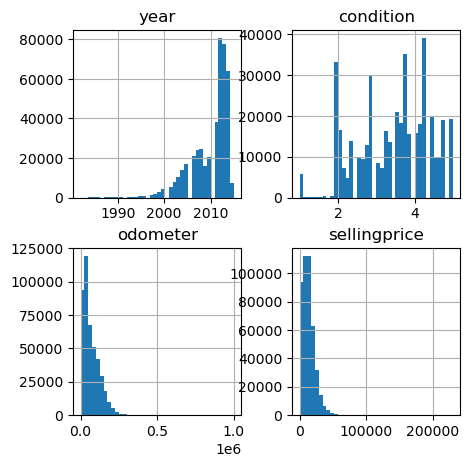

In [7]:
#к сожалению у нас только 4 числовых столбца, поэтому это не наглядно
train.hist(figsize=(5,5), bins=40);

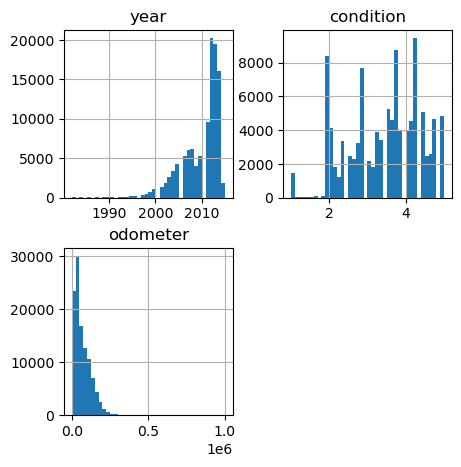

In [8]:
test.hist(figsize=(5,5), bins=40);

    Распределение по годам, значения одометра и цена на аукционе похожи на экспоненциальное распределение.

### Предобработка данных

In [9]:
#проверим кол-во полных дубликатов
train.duplicated().sum()

0

In [10]:
test.duplicated().sum()

0

Проведем простую предобработку данных: уберем лишние символы в начале и конце строки, а так же все данные передем в нижний регистр.

In [11]:
#за 1 цикл убрали и символы и перевели в нижний регистр
for i in train.select_dtypes(include='object'):
    train[i] =  train[i].str.strip('._- ')
    train[i] = train[i].str.lower()

In [12]:
for i in train.select_dtypes(include='object'):
    test[i] =  test[i].str.strip('._- ')
    test[i] = test[i].str.lower()

#### Обработка пропусков

In [13]:
[f'Пропущено {train[column].isna().sum()/len(train):.3f} данных в столбце {column}' for column in train.columns]

['Пропущено 0.000 данных в столбце year',
 'Пропущено 0.018 данных в столбце make',
 'Пропущено 0.018 данных в столбце model',
 'Пропущено 0.019 данных в столбце trim',
 'Пропущено 0.024 данных в столбце body',
 'Пропущено 0.117 данных в столбце transmission',
 'Пропущено 0.000 данных в столбце vin',
 'Пропущено 0.000 данных в столбце state',
 'Пропущено 0.021 данных в столбце condition',
 'Пропущено 0.000 данных в столбце odometer',
 'Пропущено 0.001 данных в столбце color',
 'Пропущено 0.001 данных в столбце interior',
 'Пропущено 0.000 данных в столбце seller',
 'Пропущено 0.000 данных в столбце sellingprice',
 'Пропущено 0.000 данных в столбце saledate']

In [14]:
[f'Пропущено {test[column].isna().sum()/len(test):.3f} данных в столбце {column}' for column in test.columns]

['Пропущено 0.000 данных в столбце year',
 'Пропущено 0.019 данных в столбце make',
 'Пропущено 0.019 данных в столбце model',
 'Пропущено 0.019 данных в столбце trim',
 'Пропущено 0.024 данных в столбце body',
 'Пропущено 0.118 данных в столбце transmission',
 'Пропущено 0.000 данных в столбце vin',
 'Пропущено 0.000 данных в столбце state',
 'Пропущено 0.022 данных в столбце condition',
 'Пропущено 0.000 данных в столбце odometer',
 'Пропущено 0.001 данных в столбце color',
 'Пропущено 0.001 данных в столбце interior',
 'Пропущено 0.000 данных в столбце seller',
 'Пропущено 0.000 данных в столбце saledate']

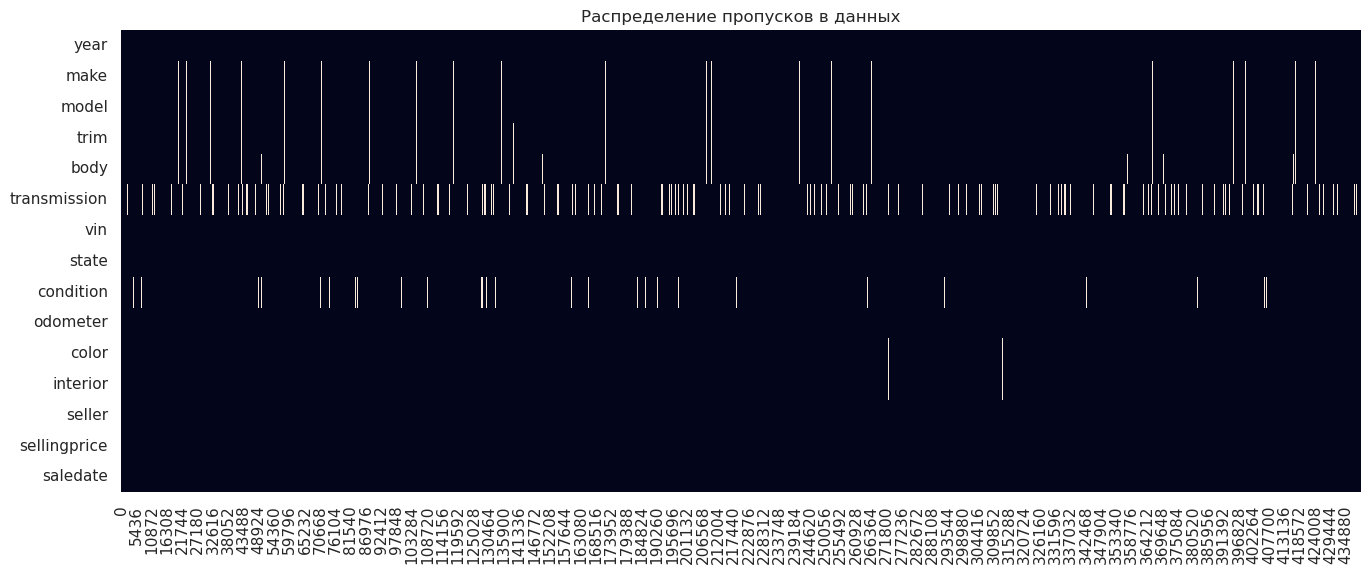

In [15]:
sns.set(rc = {'figure.figsize':(16,6)})
#нам необходимы только пропуски (наличие или отсутствие данных), поэтому используем .isna()
#транспонируем (меняем местами столбцы со строками местами) для лучшей визуализации, испробовал разные варианты
sns.heatmap(train.isna().transpose(), cbar=False).set_title('Распределение пропусков в данных');

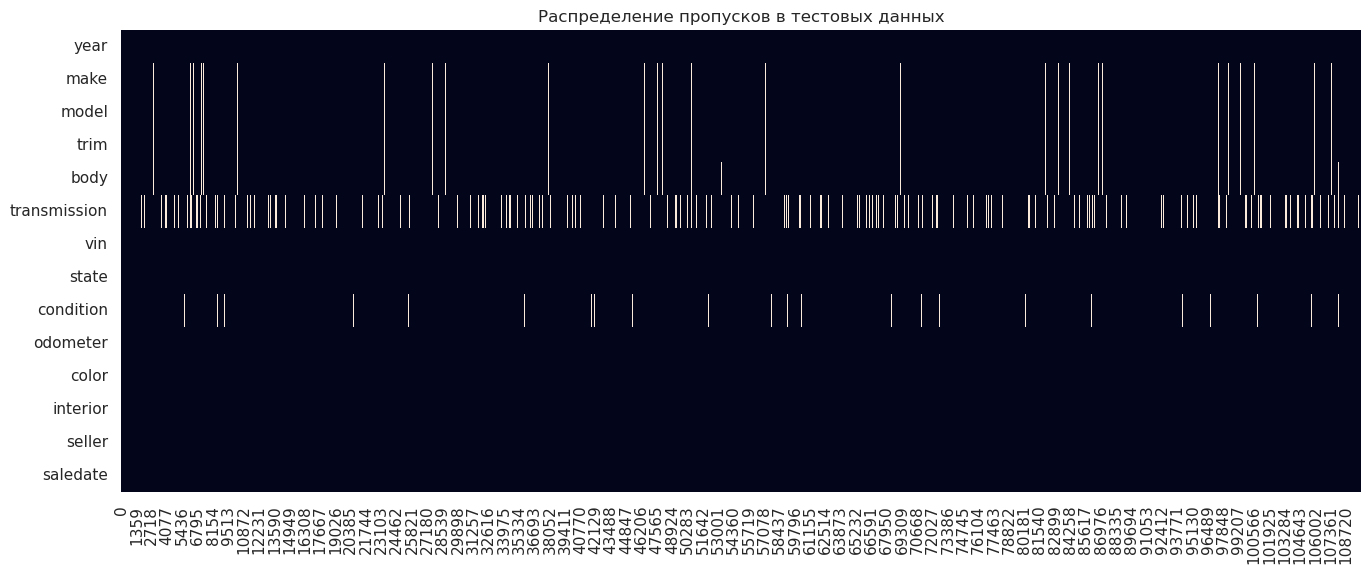

In [16]:
sns.heatmap(test.isna().transpose(), cbar=False).set_title('Распределение пропусков в тестовых данных');

In [17]:
train[train['make'].isnull()]

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
10,2007,NaN,NaN,NaN,NaN,automatic,5tfbv54157x019560,ca,3.1,102507.0,blue,gray,aaero sweet company,17250,thu jan 29 2015 03:30:00 gmt-0800 (pst)
42,2007,NaN,NaN,NaN,NaN,manual,jm1bk34l671745431,md,2.8,92656.0,blue,gray,credit acceptance corp/vrs/southfield,5600,tue jun 16 2015 02:30:00 gmt-0700 (pdt)
63,2011,NaN,NaN,NaN,NaN,automatic,1fdne1bw5bda64735,ga,5.0,67159.0,white,gray,"vpsi, inc",13200,thu jun 04 2015 03:00:00 gmt-0700 (pdt)
64,2008,NaN,NaN,NaN,NaN,automatic,1gbdv13wx8d142776,ca,4.1,113582.0,white,gray,wholesale motor sales inc,4100,thu feb 05 2015 04:00:00 gmt-0800 (pst)
111,2006,NaN,NaN,NaN,NaN,automatic,3gnda13d36s611801,nv,2.8,129019.0,orange,gray,credit acceptance corp/vrs/southfield,2900,thu feb 05 2015 04:00:00 gmt-0800 (pst)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440085,2011,NaN,NaN,NaN,NaN,automatic,1fdne1bw8bdb21610,az,3.5,80594.0,white,gray,mike albert fleet solutions,11100,wed feb 04 2015 03:00:00 gmt-0800 (pst)
440114,2011,NaN,NaN,NaN,NaN,automatic,2lnbl8ev9bx757689,nj,3.5,134164.0,—,black,merchants automotive group,11800,wed mar 04 2015 01:30:00 gmt-0800 (pst)
440118,2004,NaN,NaN,NaN,NaN,automatic,1gyde637240130408,md,3.5,123123.0,white,beige,credit acceptance corp/vrs/southfield,3400,tue feb 17 2015 01:30:00 gmt-0800 (pst)
440122,2007,NaN,NaN,NaN,NaN,automatic,salme15487a251642,ca,2.5,39545.0,black,black,hornburg jaguar,17750,wed jun 17 2015 05:15:00 gmt-0700 (pdt)


In [18]:
test[test['make'].isnull()]

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate
22,2006,NaN,NaN,NaN,NaN,automatic,3gnda23d06s523147,pa,2.4,143377.0,blue,gray,ryan mtrs of morristown inc,fri jan 23 2015 01:00:00 gmt-0800 (pst)
72,2000,NaN,NaN,NaN,NaN,manual,1j4fa59s0yp723644,mo,NaN,76674.0,black,—,effingham auto care & tire inc,mon dec 22 2014 11:00:00 gmt-0800 (pst)
220,2003,NaN,NaN,NaN,NaN,automatic,jtjbt20x930014425,tx,4.9,107337.0,silver,gray,fairway ford henderson,wed feb 18 2015 02:00:00 gmt-0800 (pst)
237,1998,NaN,NaN,NaN,NaN,automatic,1j4gz78yxwc163618,nv,2.0,243163.0,gray,—,titlemax/las vegas nv32,thu feb 19 2015 03:00:00 gmt-0800 (pst)
287,2009,NaN,NaN,NaN,NaN,automatic,1gbhg39c591143468,pa,2.1,179884.0,white,gray,lease plan usa,tue feb 24 2015 01:30:00 gmt-0800 (pst)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109622,2007,NaN,NaN,NaN,NaN,automatic,jm1fe173470212203,wa,2.0,133227.0,blue,beige,primus automotive financial services,wed feb 11 2015 04:35:00 gmt-0800 (pst)
109665,2010,NaN,NaN,NaN,NaN,automatic,4a32b2ff4ae011675,fl,2.9,69783.0,black,gray,premier partners inc,thu jan 15 2015 02:30:00 gmt-0800 (pst)
109717,1999,NaN,NaN,NaN,NaN,automatic,1gcdl19w1xb115016,pa,3.7,179570.0,white,blue,ari,tue feb 10 2015 01:30:00 gmt-0800 (pst)
109948,2006,NaN,NaN,NaN,NaN,automatic,2hjyk16546h509272,md,3.2,107466.0,white,beige,wells fargo dealer services,tue may 26 2015 02:30:00 gmt-0700 (pdt)


Пропуски в колонках make, model, trim можно заменить модой. Но при этом самая частая марка и самая частая модель могут не принадлежать к одному авто, так что колонку model заменим на моду внутри определенной марки.

In [19]:
mode_make = train['make'].mode()[0]
mode_model = train[train['make']=='ford']['model'].mode()[0]
mode_trim = train[(train['make']=='ford')&(train['model']=='f-150')]['trim'].mode()[0]

In [20]:
train['make'].fillna(mode_make, inplace=True)
test['make'].fillna(mode_make, inplace=True)

train['model'].fillna(mode_model, inplace=True)
test['model'].fillna(mode_model, inplace=True)

train['trim'].fillna(mode_trim, inplace=True)
test['trim'].fillna(mode_trim, inplace=True)

##### Обработка make

In [21]:
train['make'].sort_values().unique()

array(['acura', 'airstream', 'aston martin', 'audi', 'bentley', 'bmw',
       'buick', 'cadillac', 'chevrolet', 'chrysler', 'daewoo', 'dodge',
       'dodge tk', 'dot', 'ferrari', 'fiat', 'fisker', 'ford',
       'ford truck', 'geo', 'gmc', 'gmc truck', 'honda', 'hummer',
       'hyundai', 'infiniti', 'isuzu', 'jaguar', 'jeep', 'kia',
       'lamborghini', 'land rover', 'landrover', 'lexus', 'lincoln',
       'maserati', 'mazda', 'mazda tk', 'mercedes', 'mercedes-b',
       'mercedes-benz', 'mercury', 'mini', 'mitsubishi', 'nissan',
       'oldsmobile', 'plymouth', 'pontiac', 'porsche', 'ram',
       'rolls-royce', 'saab', 'saturn', 'scion', 'smart', 'subaru',
       'suzuki', 'tesla', 'toyota', 'volkswagen', 'volvo', 'vw'],
      dtype=object)

In [22]:
test['make'].sort_values().unique()

array(['acura', 'aston martin', 'audi', 'bentley', 'bmw', 'buick',
       'cadillac', 'chev truck', 'chevrolet', 'chrysler', 'daewoo',
       'dodge', 'ferrari', 'fiat', 'fisker', 'ford', 'ford tk', 'geo',
       'gmc', 'honda', 'hummer', 'hyundai', 'hyundai tk', 'infiniti',
       'isuzu', 'jaguar', 'jeep', 'kia', 'land rover', 'landrover',
       'lexus', 'lincoln', 'lotus', 'maserati', 'mazda', 'mercedes',
       'mercedes-benz', 'mercury', 'mini', 'mitsubishi', 'nissan',
       'oldsmobile', 'plymouth', 'pontiac', 'porsche', 'ram',
       'rolls-royce', 'saab', 'saturn', 'scion', 'smart', 'subaru',
       'suzuki', 'tesla', 'toyota', 'volkswagen', 'volvo', 'vw'],
      dtype=object)

In [23]:
dict_make = {
    'landrover': 'land rover',
    'mercedes-b': 'mercedes',
    'mercedes-benz': 'mercedes',
    'vw': 'volkswagen',
}

In [24]:
train['make'] = train['make'].replace(dict_make)

In [25]:
test['make'] = test['make'].replace(dict_make)

##### Обработка model

In [26]:
train['model'].sort_values().unique()

array(['1 series', '1500', '190-class', '2 series', '200', '200sx',
       '2500', '3', '3 series', '3 series gran turismo', '300',
       '300-class', '3000gt', '300e', '300m', '300zx', '320i', '323i',
       '328i', '3500', '350z', '370z', '4 series', '4 series gran coupe',
       '400-class', '420-class', '420sel', '42c', '458 italia', '4runner',
       '5 series', '5 series gran turismo', '500', '500-class', '500e',
       '500l', '6', '6 series', '6 series gran coupe', '626', '7',
       '7 series', '750i', '750li', '750lxi', '8 series', '850', '9-2x',
       '9-3', '9-5', '9-7x', '911', '940', '960', 'a3', 'a4', 'a5', 'a6',
       'a7', 'a8', 'acadia', 'accent', 'accord', 'accord crosstour',
       'accord hybrid', 'activehybrid 5', 'activehybrid 7',
       'activehybrid x6', 'aerio', 'alero', 'allroad', 'allroad quattro',
       'alp', 'altima', 'altima hybrid', 'amanti', 'amigo', 'armada',
       'ascender', 'aspen', 'aspire', 'astra', 'astro', 'astro cargo',
       'ats', 'aur

Значений много, явных ошибок не обнаружено.

Можно предположить что некоторые модели (например '3 series' и  '3 series gran turismo') можно привести к одному виду, т.к. мы их сможет отличть по типу кузова (седан и хэтчбек), но в реальных данных не будет '3 series' в кузове хэтчбек, только '3 series gran turismo' и мы можем пропустить такие предсказания, так что данный столбец оставляем без изменений.

##### Обработка trim

In [27]:
train['trim'].sort_values().unique()

array(['!', '& coun fwd', '& coun fwd limited', ..., 'zx5 se', 'zx5 ses',
       'zxw ses'], dtype=object)

In [28]:
test['trim'].sort_values().unique()

array(['!', '& coun fwd limited', '& country lx', ..., 'zx5 se',
       'zx5 ses', 'zxw ses'], dtype=object)

Видим присутствие каких-то символов в названии версии авто.

In [29]:
train['trim'].value_counts()

base                      43876
se                        34498
xlt                       21510
lx                        16511
limited                   14526
                          ...  
executive pzev                1
4c base                       1
3500 sh ceiling 158 wb        1
chevy van base                1
4x4 v6 xlt sport              1
Name: trim, Length: 1840, dtype: int64

Найдем все строки, которые содержат эти символы.

In [30]:
#Поиск строк, содержащих определенные символы и двойные пробелы
result = train[train['trim'].str.contains('[!@#$%^&*()]', regex=True)]
result['trim'].value_counts()

!                               368
carrera s (midyear redesign)     15
& country lx                     13
gls (1999.5)                      9
& coun fwd lx                     7
(1999.5) xe                       6
gl (1999.5)                       5
xe (1997.5)                       4
base (1999.5)                     4
gls vr6 (1999.5)                  1
& coun fwd                        1
glx vr6 (1999.5)                  1
limited (1994.5)                  1
& coun fwd limited                1
Name: trim, dtype: int64

In [31]:
# Поиск строк, содержащих определенные символы и двойные пробелы
result1 = test[test['trim'].str.contains('[!@#$%^&*()]', regex=True)]
result1['trim'].value_counts()

!                               83
gls (1999.5)                     8
carrera s (midyear redesign)     6
base (1999.5)                    4
xe (1997.5)                      3
& country lx                     2
& coun fwd limited               2
(1999.5) xe                      1
gl (1999.5)                      1
limited (1994.5)                 1
glx vr6 (1999.5)                 1
Name: trim, dtype: int64

In [32]:
result[result['trim']=='!'].sort_values(by='make')

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
114,2010,kia,soul,!,wagon,automatic,kndjt2a28a7133671,fl,3.6,49074.0,green,black,remarketing by ge/space coast credit union,9500,wed jan 21 2015 01:00:00 gmt-0800 (pst)
291405,2011,kia,soul,!,wagon,automatic,kndjt2a27b7224643,fl,3.7,93430.0,black,black,santander consumer,8900,thu jan 29 2015 01:35:00 gmt-0800 (pst)
290250,2010,kia,soul,!,wagon,NaN,kndjt2a26a7038879,md,1.9,91813.0,white,black,capital one auto finance,5000,tue jan 13 2015 09:30:00 gmt-0800 (pst)
287154,2011,kia,soul,!,wagon,automatic,kndjt2a29b7275917,ga,2.4,56004.0,orange,black,wells fargo dealer services,7700,thu dec 18 2014 10:00:00 gmt-0800 (pst)
287109,2010,kia,soul,!,wagon,manual,kndjt2a27a7037272,ga,2.9,116744.0,white,black,nalley kia,6300,tue feb 03 2015 05:00:00 gmt-0800 (pst)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126920,2011,kia,soul,!,wagon,NaN,kndjt2a2xb7289499,ns,4.6,151441.0,orange,gray,tantramar chevrolet buick gmc (2009) ltd,6800,wed may 27 2015 01:30:00 gmt-0700 (pdt)
126806,2010,kia,soul,!,wagon,NaN,kndjt2a21a7045593,ny,2.1,114688.0,green,black,fleet lease disposal,4450,wed jan 07 2015 09:30:00 gmt-0800 (pst)
125189,2011,kia,soul,!,wagon,automatic,kndjt2a23b7242332,ca,3.3,70790.0,black,black,mas financial services,8500,wed feb 11 2015 04:05:00 gmt-0800 (pst)
138450,2010,kia,soul,!,wagon,automatic,kndjt2a20a7702464,ca,2.1,99273.0,white,black,first investors servicing corp,7300,tue dec 16 2014 12:30:00 gmt-0800 (pst)


In [33]:
result[(result['make']=='kia') & (result['model']=='soul')].sort_values(by='trim')

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
114,2010,kia,soul,!,wagon,automatic,kndjt2a28a7133671,fl,3.6,49074.0,green,black,remarketing by ge/space coast credit union,9500,wed jan 21 2015 01:00:00 gmt-0800 (pst)
291405,2011,kia,soul,!,wagon,automatic,kndjt2a27b7224643,fl,3.7,93430.0,black,black,santander consumer,8900,thu jan 29 2015 01:35:00 gmt-0800 (pst)
290250,2010,kia,soul,!,wagon,NaN,kndjt2a26a7038879,md,1.9,91813.0,white,black,capital one auto finance,5000,tue jan 13 2015 09:30:00 gmt-0800 (pst)
287154,2011,kia,soul,!,wagon,automatic,kndjt2a29b7275917,ga,2.4,56004.0,orange,black,wells fargo dealer services,7700,thu dec 18 2014 10:00:00 gmt-0800 (pst)
287109,2010,kia,soul,!,wagon,manual,kndjt2a27a7037272,ga,2.9,116744.0,white,black,nalley kia,6300,tue feb 03 2015 05:00:00 gmt-0800 (pst)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126920,2011,kia,soul,!,wagon,NaN,kndjt2a2xb7289499,ns,4.6,151441.0,orange,gray,tantramar chevrolet buick gmc (2009) ltd,6800,wed may 27 2015 01:30:00 gmt-0700 (pdt)
126806,2010,kia,soul,!,wagon,NaN,kndjt2a21a7045593,ny,2.1,114688.0,green,black,fleet lease disposal,4450,wed jan 07 2015 09:30:00 gmt-0800 (pst)
125189,2011,kia,soul,!,wagon,automatic,kndjt2a23b7242332,ca,3.3,70790.0,black,black,mas financial services,8500,wed feb 11 2015 04:05:00 gmt-0800 (pst)
138450,2010,kia,soul,!,wagon,automatic,kndjt2a20a7702464,ca,2.1,99273.0,white,black,first investors servicing corp,7300,tue dec 16 2014 12:30:00 gmt-0800 (pst)


Погуглив и погрузившись в мир моделей авто, стало ясно, что ошибки тут в сроках содержащих "coun" вместо "country".
При этом "!" хоть и является ошибкой, но эти значения содержат одна и та же модель и НИКАКИХ других значений в колонке "trim" нет, видимо так заполняли отсутствие значения именно для этой модели.
Заменим на значение "unknown", т.к. будущие модели могут некорректно воспринять этот символ.

In [34]:
train['trim'] = train['trim'].replace('!', 'unknown')

In [35]:
test['trim'] = test['trim'].replace('!', 'unknown')

##### Обработка body

In [36]:
train['body'].isnull().sum()

10393

In [37]:
test['body'].isnull().sum()

2594

In [38]:
train['body'].sort_values().unique()

array(['access cab', 'beetle convertible', 'cab plus', 'cab plus 4',
       'club cab', 'convertible', 'coupe', 'crew cab', 'crewmax cab',
       'cts coupe', 'cts wagon', 'cts-v coupe', 'cts-v wagon',
       'double cab', 'e-series van', 'elantra coupe', 'extended cab',
       'g convertible', 'g coupe', 'g sedan', 'g37 convertible',
       'g37 coupe', 'genesis coupe', 'granturismo convertible',
       'hatchback', 'king cab', 'koup', 'mega cab', 'minivan',
       'promaster cargo van', 'q60 convertible', 'q60 coupe', 'quad cab',
       'ram van', 'regular cab', 'regular-cab', 'sedan', 'supercab',
       'supercrew', 'suv', 'transit van', 'tsx sport wagon', 'van',
       'wagon', 'xtracab', nan], dtype=object)

In [39]:
test['body'].sort_values().unique()

array(['access cab', 'beetle convertible', 'cab plus', 'club cab',
       'convertible', 'coupe', 'crew cab', 'crewmax cab', 'cts coupe',
       'cts wagon', 'cts-v coupe', 'double cab', 'e-series van',
       'elantra coupe', 'extended cab', 'g convertible', 'g coupe',
       'g sedan', 'g37 convertible', 'g37 coupe', 'genesis coupe',
       'granturismo convertible', 'hatchback', 'king cab', 'koup',
       'mega cab', 'minivan', 'promaster cargo van', 'q60 convertible',
       'q60 coupe', 'quad cab', 'regular cab', 'regular-cab', 'sedan',
       'supercab', 'supercrew', 'suv', 'transit van', 'tsx sport wagon',
       'van', 'wagon', 'xtracab', nan], dtype=object)

In [40]:
#создадим словарь с неправильными названиям
dict_body = {'g convertible': 'convertible',
'q60 convertible': 'convertible',
'g37 convertible': 'convertible',
'beetle convertible': 'convertible',
'granturismo convertible': 'convertible',
'g sedan': 'sedan',
'g coupe': 'coupe',
'q60 coupe': 'coupe',
'genesis coupe': 'coupe',
'elantra coupe': 'coupe',
'cts coupe': 'coupe',
'koup': 'coupe',
'g37 coupe': 'coupe',
'promaster cargo van': 'van',
'transit van': 'van',
'tsx sport wagon': 'wagon',
            }

In [41]:
#заменим эти значения
train['body'] = train['body'].replace(dict_body)

In [42]:
test['body'] = test['body'].replace(dict_body)

#удалим строки, где содержится меньше 10-ти типов кузовов (редкие авто, можно считать за выбросы)
counts_body = train['body'].value_counts()
body_counts_less_than_10 = counts_body[counts_body < 10].index
train = train[~train['body'].isin(body_counts_less_than_10)]

Пропуски можно заполнить самыми часто встречающимися значениями (модой) в колонках "make" + "model".

In [43]:
train['body'] = train.groupby(['make', 'model'])['body'].transform(lambda x: x.fillna(x.mode().iat[0]) if x.mode().size > 0 else x)

In [44]:
#проверим кол-во пропусков и удалим их
train['body'].isnull().sum()

850

In [45]:
train = train.dropna(subset=['body'])

Заменим пропуски в test на моду из обучающей выборки.

In [46]:
test['body'] = test['body'].fillna(train.groupby(['make', 'model'])['body'].transform(
    lambda x: x.fillna(x.mode().iat[0])
)
                                  )

In [47]:
test[test['body'].isnull()].sort_values(by='make')[['make', 'model','body']]

,make,model,body
57282,ford,f-150,NaN
105820,ford,f-150,NaN
10044,honda,pilot,NaN
24461,mitsubishi,galant,NaN


Как видим код отработал не совсем корректно, скорее всего в комбинациях make-model отсутствует мода для этих конкретных данных. Заменим пропуски на первую попавшуюся комбинацию из train.

In [48]:
test['body'] = test.apply(
    lambda row: train.loc[
        (train['make'] == row['make']) & (train['model'] == row['model']),
        'body'
    ].iloc[0] 
        if pd.isnull(row['body']) 
        else row['body'], axis=1)

In [49]:
test['body'].isnull().sum()

0

##### Обработка transmission

In [50]:
train['transmission'].value_counts()

automatic    374377
manual        13690
Name: transmission, dtype: int64

In [51]:
test['transmission'].value_counts()

automatic    93584
manual        3463
Name: transmission, dtype: int64

In [52]:
train['transmission'].isnull().sum()

51319

In [53]:
test['transmission'].isnull().sum()

13011

Аналогично заменим пропуски в данном столбце самыми часто встречающимися значениями

In [54]:
train.loc[:,'transmission'] = train.groupby(['make', 'model'])['transmission'].transform(
    lambda x: x.fillna(x.mode().iat[0])
    if x.mode().size > 0
    else x
)

In [55]:
train['transmission'].isnull().sum()

5

In [56]:
#удалим эти строки
train = train.dropna(subset=['transmission'])

In [57]:
test['transmission'] = test['transmission'].fillna(train.groupby(['make', 'model'])['transmission'].transform(
    lambda x: x.fillna(x.mode().iat[0])
)
                                  )

In [58]:
test['transmission'].isnull().sum()

25

In [59]:
train['transmission'].isnull().sum()

0

##### Обработка vin

Длина vin номера всегда равняется 17 знакам, проверим, сущесвуют ли аномалии по кол-ву символов.

In [60]:
# Создаем столбец с длиной текстового значения
train['vin_length'] = train['vin'].apply(len)

# Поиск аномалий
train[train['vin_length']!=17]

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate,vin_length


In [61]:
# Создаем столбец с длиной текстового значения
test['vin_length'] = test['vin'].apply(len)

# Поиск аномалий
test[test['vin_length']!=17]

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate,vin_length


In [62]:
#удалим лишний столбец
del train['vin_length']

In [63]:
del test['vin_length']

Проверим на дубликаты

In [64]:
train['vin'].duplicated().sum()

0

In [65]:
test['vin'].duplicated().sum()

0

##### Обработка state

In [66]:
train['state'].sort_values().unique()

array(['ab', 'al', 'az', 'ca', 'co', 'fl', 'ga', 'hi', 'il', 'in', 'la',
       'ma', 'md', 'mi', 'mn', 'mo', 'ms', 'nc', 'ne', 'nj', 'nm', 'ns',
       'nv', 'ny', 'oh', 'ok', 'on', 'or', 'pa', 'pr', 'qc', 'sc', 'tn',
       'tx', 'ut', 'va', 'wa', 'wi'], dtype=object)

In [67]:
test['state'].sort_values().unique()

array(['ab', 'al', 'az', 'ca', 'co', 'fl', 'ga', 'hi', 'il', 'in', 'la',
       'ma', 'md', 'mi', 'mn', 'mo', 'ms', 'nc', 'ne', 'nj', 'nm', 'ns',
       'nv', 'ny', 'oh', 'ok', 'on', 'or', 'pa', 'pr', 'qc', 'sc', 'tn',
       'tx', 'ut', 'va', 'wa', 'wi'], dtype=object)

Вроде всё в порядке.

##### Обработка condition

In [68]:
train['condition'].sort_values().unique()

array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2,
       2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5,
       3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8,
       4.9, 5. , nan])

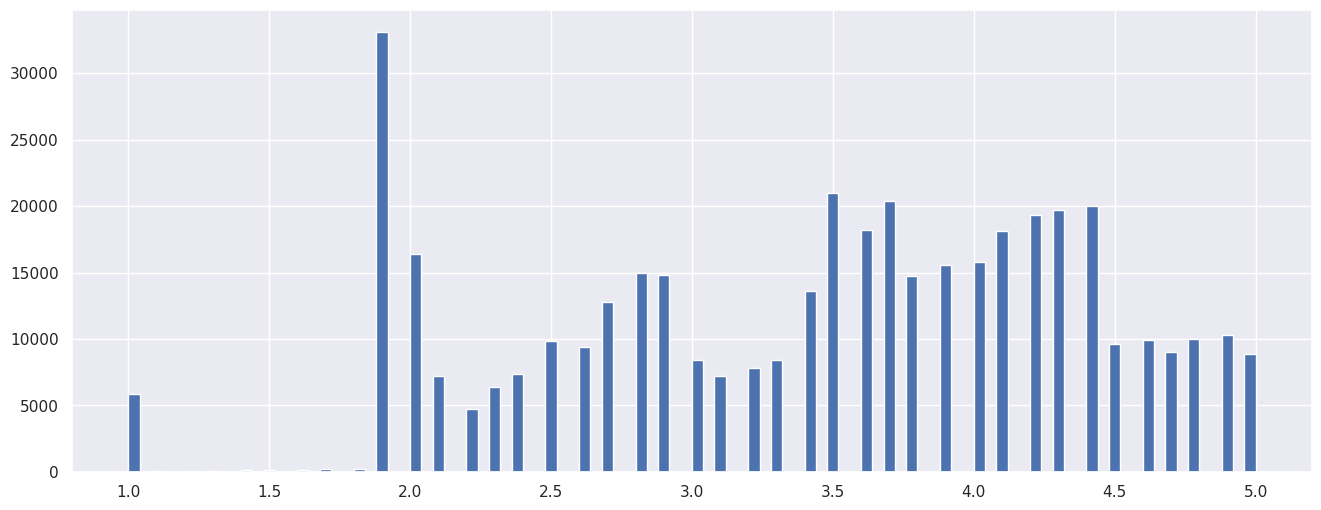

In [69]:
train['condition'].hist(bins=100);

Между 1 и примерно 1.8 практически нет данных, но при этом есть пик на 1.9 это возможно объяснить человеческим фактором: плохие машины хочется оценить чуть лучше, чтобы продать дороже, ИЛИ сложно оценить авто на эти баллы, поэтому ставили "двоечку". Необходимо проверить, есть ли связь между этой оценкой и какими-нибудь параметрами: годом, пробегом или возможно ПРОДАВЦОМ (вдруг на наших глазах творится афера.)
Аномалий нет, но есть пропуски.

In [70]:
train['condition'].isna().sum()

9267

In [71]:
#заполним пропуски самым частым значением года и модели, т.к. скорее всего эти машины 
#эксплуатировались в схожих условиях 
# + 'CONDITION' является категориальным значением
train['condition'] = train.groupby(['year', 'model'])['condition'].transform(
    lambda x: x.fillna(x.mode().iat[0])
        if x.mode().size > 0
        else x
)

In [72]:
train['condition'].isna().sum()

35

In [73]:
#удалим пропуски
train = train.dropna(subset=['condition'])

In [74]:
test['condition'].isna().sum()

2379

In [75]:
test['condition'] = test['condition'].fillna(train.groupby(['year', 'model'])['condition'].transform(
    lambda x: x.fillna(x.mode().iat[0])
)
                                  )

In [76]:
test['condition'].isna().sum()

5

In [77]:
test['condition'] = test.apply(
    lambda row: train.loc[(train['make'] == row['make']) & (train['model'] == row['model']), 'body'].iloc[0] 
        if pd.isnull(row['condition']) 
        else row['condition'], axis=1
)

In [78]:
test['condition'].isna().sum()

0

##### Обработка odometer

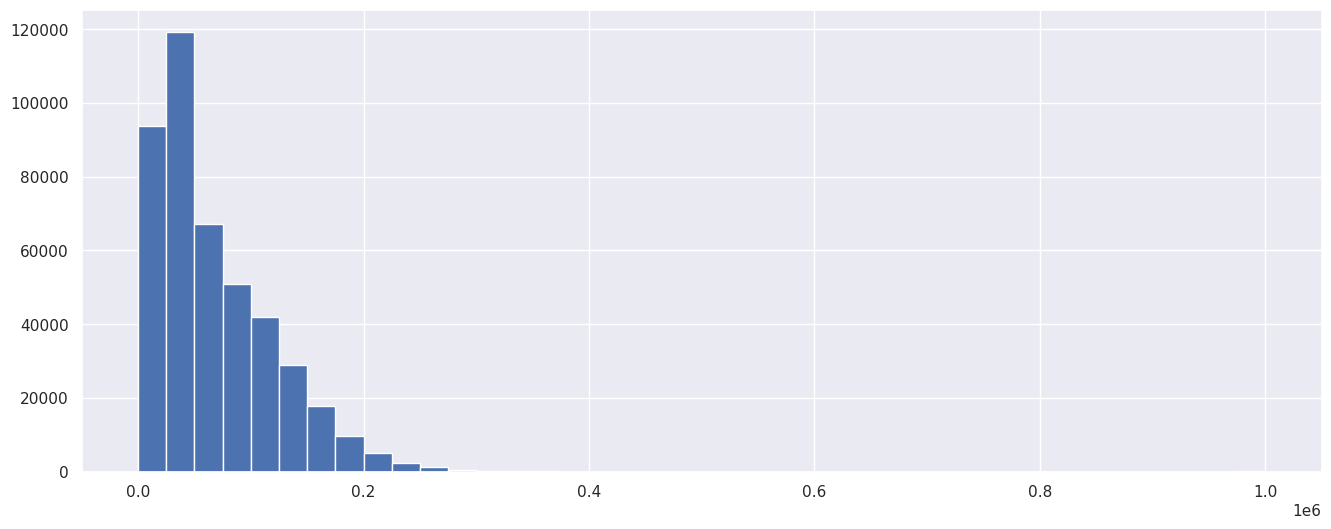

In [79]:
train['odometer'].hist(bins=40);

Значения больше 0.3*1e6 являются выбросами, но это могут быть редкие авто, и лучше хоть как-то предсказать их цену, цем вообще не предсказать.

In [80]:
train[train['odometer']>0.3*1e6].shape[0]

579

In [81]:
train['odometer'].isnull().sum()

67

In [82]:
train['odometer'] = train.groupby(['make', 'model', 'year'])['odometer'].transform(
    lambda x: x.fillna(x.mode().iat[0])
        if x.mode().size > 0
        else x
)

In [83]:
train['odometer'].isnull().sum()

0

In [84]:
test['odometer'].isnull().sum()

19

In [85]:
test['odometer'] = test['odometer'].fillna(train.groupby(['make', 'model', 'year'])['odometer'].transform(
    lambda x: x.fillna(x.mode().iat[0])
)
                                  )

In [86]:
test['odometer'].isnull().sum()

0

##### Обработка color

In [87]:
train['color'].sort_values().unique()

array(['beige', 'black', 'blue', 'brown', 'burgundy', 'charcoal', 'gold',
       'gray', 'green', 'lime', 'off-white', 'orange', 'pink', 'purple',
       'red', 'silver', 'turquoise', 'white', 'yellow', '—', nan],
      dtype=object)

In [88]:
test['color'].sort_values().unique()

array(['beige', 'black', 'blue', 'brown', 'burgundy', 'charcoal', 'gold',
       'gray', 'green', 'lime', 'off-white', 'orange', 'pink', 'purple',
       'red', 'silver', 'turquoise', 'white', 'yellow', '—', nan],
      dtype=object)

Неправильно названных цветов нет, но есть "-" и пропуски, чтобы обработать необходимо:

1) заменить "-" на пропуск
2) заменить пропуск на моду (т.к. цвета это категориальный признак)

In [89]:
train['color'] = train['color'].replace('—', np.nan)

In [90]:
train['color'] = train.groupby(['make', 'model'])['color'].transform(
    lambda x: x.fillna(x.mode().iat[0])
    if x.mode().size > 0
    else x
)

In [91]:
train['color'].isna().sum()

2

In [92]:
train = train.dropna(subset=['color'])

In [93]:
test['color'] = test['color'].replace('—', np.nan)

Цвет машины может коррелировать с маркой и моделью авто, т.к.некоторые авто могут поставляться с ограниченным набором цветов.

In [94]:
test['color'] = test['color'].fillna(train.groupby(['make', 'model'])['color'].transform(
    lambda x: x.fillna(x.mode().iat[0])
)
                                  )

In [95]:
test['color'].isna().sum()

12

In [96]:
test['color'] = test['color'].fillna(train['color'].mode().iat[0])

In [97]:
test['color'].isna().sum()

0

##### Обработка interior

In [98]:
train['interior'].sort_values().unique()

array(['beige', 'black', 'blue', 'brown', 'burgundy', 'gold', 'gray',
       'green', 'off-white', 'orange', 'purple', 'red', 'silver', 'tan',
       'white', 'yellow', '—', nan], dtype=object)

In [99]:
test['interior'].sort_values().unique()

array(['beige', 'black', 'blue', 'brown', 'burgundy', 'gold', 'gray',
       'green', 'off-white', 'orange', 'purple', 'red', 'silver', 'tan',
       'white', 'yellow', '—', nan], dtype=object)

Аналогично цвету кузова.

In [100]:
train['interior'] = train['interior'].replace('—', np.nan)

In [101]:
test['interior'] = test['interior'].replace('—', np.nan)

In [102]:
train['interior'] = train.groupby(['make', 'model'])['interior'].transform(
    lambda x: x.fillna(x.mode().iat[0])
    if x.mode().size > 0
    else x
)

In [103]:
test['interior'] = test['interior'].fillna(train.groupby(['make', 'model'])['interior'].transform(
    lambda x: x.fillna(x.mode().iat[0]) if x.mode().size > 0 else np.nan
)
                                  )

In [104]:
train['interior'].isna().sum()

2

In [105]:
train = train.dropna(subset=['interior'])

In [106]:
test['interior'].isna().sum()

10

In [107]:
test['interior'] = test['interior'].fillna(train['interior'].mode().iat[0])

##### Обработка seller

In [108]:
train['seller'].value_counts()

nissan-infiniti lt               15823
ford motor credit company,llc    15271
the hertz corporation            14691
santander consumer               12220
avis corporation                 10098
                                 ...  
778025 alberta ltd                   1
pacific auto resellers               1
tower auto sales                     1
iezzi's auto sales                   1
studio city auto group               1
Name: seller, Length: 12983, dtype: int64

Возможно имеются опечатки в названиях продацавцов, но данных слишком много для ручного поиска.
Если результаты будут плохими - возможно нужно будет группировать на частные и корпоративные по ключевым словам(company, corporation, ltd и т.п.)

##### Обработка sellingprice

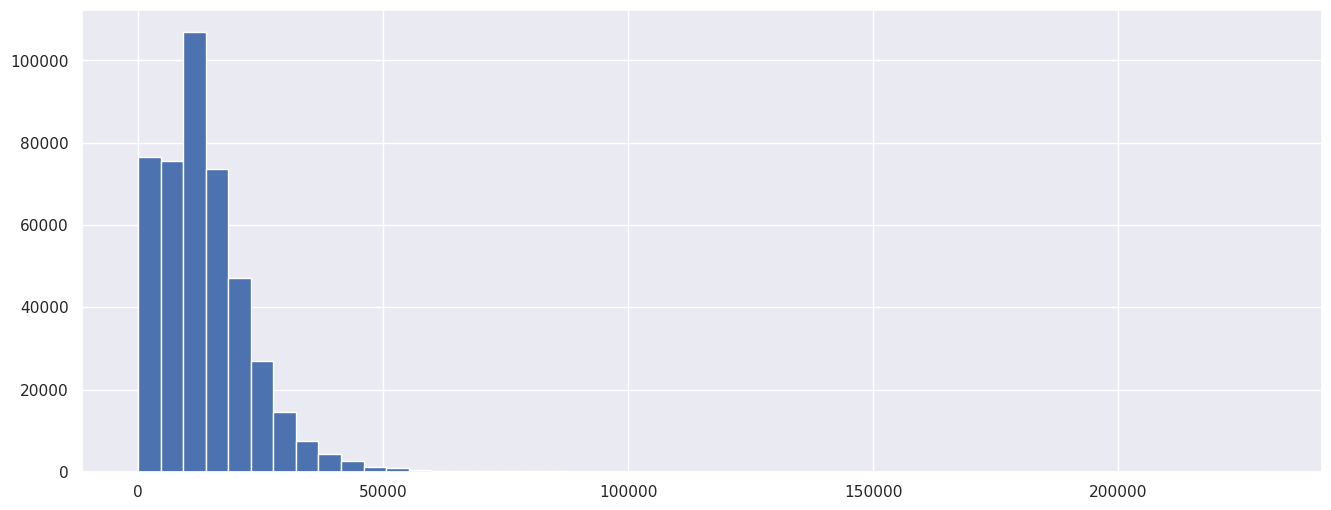

In [109]:
train['sellingprice'].hist(bins=50);

In [110]:
train[train['sellingprice']>100000].shape[0]

133

Оставим выбросы, т.к. там могут находиться редкие авто.

##### Обработка saledate

In [111]:
train['saledate'].head(5)

0    tue jun 02 2015 02:30:00 gmt-0700 (pdt)
1    wed feb 25 2015 02:00:00 gmt-0800 (pst)
2    wed jun 10 2015 02:30:00 gmt-0700 (pdt)
3    wed jun 17 2015 03:00:00 gmt-0700 (pdt)
4    tue feb 03 2015 04:00:00 gmt-0800 (pst)
Name: saledate, dtype: object

Данные имеют тип object  и не могут быть интерпретированы через встроенные библиотеки, поэтому применяем dateparser.

Возможно вытащить данные из столбца, т.к. данные имеют четкую структуру, но не хочется заморачиваться.

In [112]:
train.loc[:, 'saledate'] = train['saledate'].apply(lambda x: dateparser.parse(x.split('(')[0].strip()))

In [113]:
test.loc[:, 'saledate'] = test['saledate'].apply(lambda x: dateparser.parse(x.split('(')[0].strip()))

In [114]:
train['saledate'] = pd.to_datetime(train['saledate'], utc=True)

In [115]:
test['saledate'] = pd.to_datetime(test['saledate'], utc=True)

In [116]:
train['sale_year'] = train['saledate'].dt.year
train['sale_month'] = train['saledate'].dt.month
train['sale_day'] = train['saledate'].dt.day
train['sale_weekday'] = train['saledate'].dt.weekday
train['sale_hour'] = train['saledate'].dt.hour
del train['saledate']

In [117]:
test['sale_year'] = test['saledate'].dt.year
test['sale_month'] = test['saledate'].dt.month
test['sale_day'] = test['saledate'].dt.day
test['sale_weekday'] = test['saledate'].dt.weekday
test['sale_hour'] = test['saledate'].dt.hour

In [118]:
#del test['saledate']

#### Выводы к ОБРАБОТКА ПРОПУСКОВ

Удалено около 0.002% данных.
Пропуски замещены самыми частыми значениями в своих группах (модой), т.к. являются категориальными признаками.

#### Преобразование типов данных

Преобразуем типы данных в подходящие, чтобы ускорить и улучшить работу будущих моделей.

##### Преобразование типов object

##### Преобразование seller

Изменим продавца на категории, зависящей от кол-ва продаж.

In [119]:
seller_counts = train['seller'].value_counts()
bins = [0, 10, 100, 1000, float('inf')]  # Границы для категорий
labels = ['Low', 'Medium', 'High', 'Very High']  # Названия категорий
train['seller_category'] = pd.cut(train['seller'].map(seller_counts), bins=bins, labels=labels)

In [120]:
seller_counts1 = test['seller'].value_counts()
seller_counts1

ford motor credit company,llc           3858
nissan-infiniti lt                      3852
the hertz corporation                   3592
santander consumer                      3043
avis corporation                        2430
                                        ... 
capital bank                               1
scottsdale motor group llc                 1
uncle maxs auto sales & leasing            1
vista ford lincoln mercury of oxnard       1
autonation nissan dallas                   1
Name: seller, Length: 7619, dtype: int64

In [121]:
test['seller_category'] = pd.cut(test['seller'].map(seller_counts1), bins=bins, labels=labels)

##### Преобразование condition

In [122]:
train['condition'].corr(train['sellingprice'])

0.5472306498630284

Видим положительную корреляцию, поэтому столбец condition не стоит заменять на категории типа "плохо", "удовлетварительно", "хорошо" и т.п.

Оставим столбец как есть, но заменим его на категории, для этого создадим список с "состоянием" и учетом иерархии данных.

In [123]:
condition_list = [str(x / 10) for x in range(10, 51)]

In [124]:
train['condition_cat'] = pd.Categorical(
    train['condition'].astype(str),
    categories=condition_list,
    ordered=True
)

In [125]:
test['condition_cat'] = pd.Categorical(
    test['condition'].astype(str),
    categories=condition_list,
    ordered=True
)

In [126]:
test['condition_cat'].head()

0    2.7
1    4.4
2    4.6
3    2.3
4    2.9
Name: condition_cat, dtype: category
Categories (41, object): ['1.0' < '1.1' < '1.2' < '1.3' ... '4.7' < '4.8' < '4.9' < '5.0']

##### Преобразование odometer

Конкретные значения пробега не имеют особой важности, но порядок(масштаб) имебт значение, поэтому масштабирование данного столбца не подойдет.

Пробег в 50к считается нормальным, поэтому разделим значения одометра на группы в 50к.

In [127]:
bins = [0, 50000, 100000, 150000, 200000, float('inf')]
labels = ['<50k', '50k-100k','100k-150k', '150k-200k', '200k+']
train['odometer_cat'] = pd.cut(
    train['odometer'],
    bins=bins,
    labels=labels, 
    ordered = True,
)

In [128]:
test['odometer_cat'] = pd.cut(
    test['odometer'],
    bins=bins,
    labels=labels, 
    ordered = True,
)

##### Feature enginnering

##### Добавление колонки из vin

По номеру vin, можно узнать много информации об авто, чтобы не перенагружать задачу, возьмем только регион происхождения авто, он может иметь большой вклад в прогноз.

In [129]:
conditions = [
    train['vin'].str.startswith(('1', '2', '3', '4', '5')),
    train['vin'].str.startswith(('6', '7')),
    train['vin'].str.startswith(('8', '9')),
    train['vin'].str.startswith(('a', 'b', 'c', 'd', 'e', 'f', 'g', 'h')),
    train['vin'].str.startswith(('j', 'k', 'l', 'm', 'n')),
    train['vin'].str.startswith(('s', 't', 'u', 'v', 'w', 'x', 'y', 'z'))
]

choices = ['na', 'oc', 'sa', 'af', 'as', 'eu']

train['region_origin'] = np.select(conditions, choices, default='unknown')

In [130]:
train['region_origin'].value_counts()

na    325673
as     69853
eu     43566
oc       168
sa        82
Name: region_origin, dtype: int64

In [131]:
conditions_test = [
    test['vin'].str.startswith(('1', '2', '3', '4', '5')),
    test['vin'].str.startswith(('6', '7')),
    test['vin'].str.startswith(('8', '9')),
    test['vin'].str.startswith(('a', 'b', 'c', 'd', 'e', 'f', 'g', 'h')),
    test['vin'].str.startswith(('j', 'k', 'l', 'm', 'n')),
    test['vin'].str.startswith(('s', 't', 'u', 'v', 'w', 'x', 'y', 'z'))
]


test['region_origin'] = np.select(conditions_test, choices, default='unknown')

##### Добавляем столбец возраст

Сам по себе год производства нам не нужен, нам нужна разница между годом его производство и датой его продажи, т.е. узнать "возраст". Поэтому из двух колонок можно сделать одну.

In [132]:
train['age'] = train['sale_year'] - train['year']

In [133]:
test['age'] = test['sale_year'] - test['year']

<Axes: xlabel='age', ylabel='odometer'>

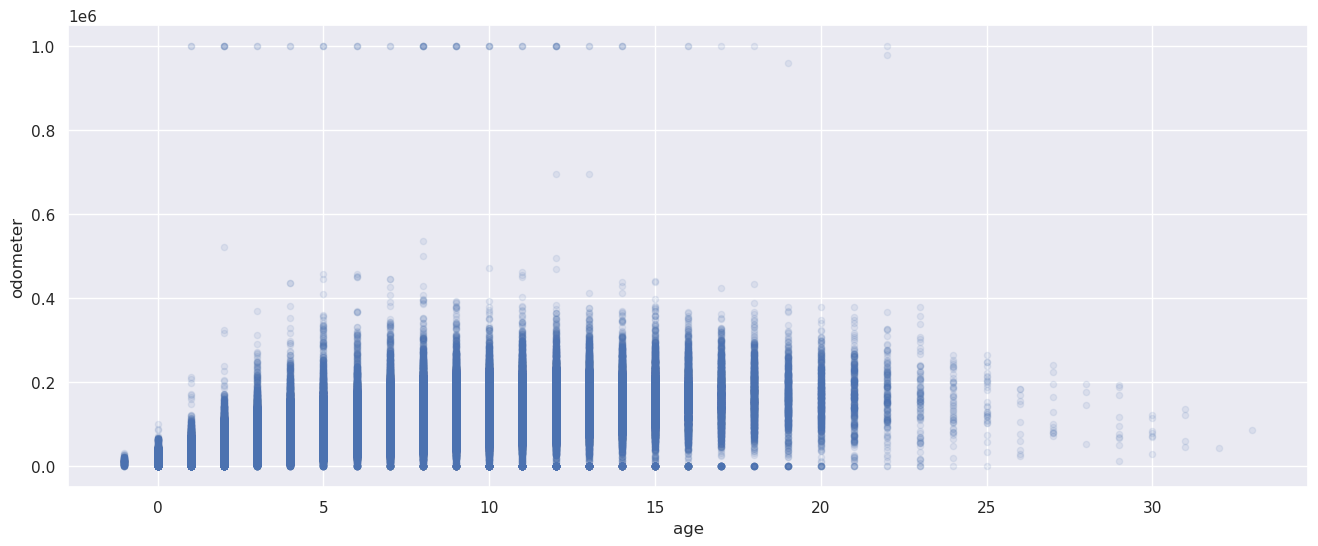

In [134]:
train.plot(x='age', y='odometer', kind='scatter', alpha=0.1) 

Видим что есть авто с отрицальным возрастом, можно предположить что dateparse сработал некорректно, или что авто были и куплены по предоплате, т.е. сделка заключена ранее, чем был произведен автомобиль, но в таком случае возраст авто будет равняться 0 годам, 0 месяцам и т.д.
Т.к. задача состоит в предсказании стоимости авто на ВТОРИЧНОМ рынке, то это можно считать выбросами. Узнаем кол-во таких авто.

In [135]:
#авто с отрицательным возрастом
train[train['age']==-1].shape[0]

166

In [136]:
#удаляем строки где возраст отрицателен
train = train[train['age']!=-1]

In [137]:
test[test['age']==-1].shape[0]

35

In [138]:
test.loc[test['age'] == -1, 'age'] = 0

In [139]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 439176 entries, 0 to 440235
Data columns (total 24 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   year             439176 non-null  int64   
 1   make             439176 non-null  object  
 2   model            439176 non-null  object  
 3   trim             439176 non-null  object  
 4   body             439176 non-null  object  
 5   transmission     439176 non-null  object  
 6   vin              439176 non-null  object  
 7   state            439176 non-null  object  
 8   condition        439176 non-null  float64 
 9   odometer         439176 non-null  float64 
 10  color            439176 non-null  object  
 11  interior         439176 non-null  object  
 12  seller           439176 non-null  object  
 13  sellingprice     439176 non-null  int64   
 14  sale_year        439176 non-null  int64   
 15  sale_month       439176 non-null  int64   
 16  sale_day         439

(None, None)

In [140]:
#Типы данных имеющие типы данных object изменим на категориальный тип дынных
for column in train.columns:
    if train[column].dtype == 'object':
        train.loc[:, column] = train[column].astype('category').copy()

/tmp/ipykernel_32/1512535655.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[:, column] = train[column].astype('category').copy()
/tmp/ipykernel_32/1512535655.py:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  train.loc[:, column] = train[column].astype('category').copy()
/tmp/ipykernel_32/1512535655.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

In [141]:
for column in test.columns:
    if test[column].dtype == 'object':
        test.loc[:, column] = test[column].astype('category').copy()

/tmp/ipykernel_32/1408909859.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test.loc[:, column] = test[column].astype('category').copy()
/tmp/ipykernel_32/1408909859.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test.loc[:, column] = test[column].astype('category').copy()
/tmp/ipykernel_32/1408909859.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if column

##### Преобразование age

In [142]:
age_list = [x for x in range(0, 34)]
train['age_cat'] = pd.Categorical(
    train['age'],
    categories=age_list,
    ordered=True
)
test['age_cat'] = pd.Categorical(
    test['age'],
    categories=age_list,
    ordered=True
)

/tmp/ipykernel_32/423633693.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['age_cat'] = pd.Categorical(


In [143]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 439176 entries, 0 to 440235
Data columns (total 25 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   year             439176 non-null  int64   
 1   make             439176 non-null  category
 2   model            439176 non-null  category
 3   trim             439176 non-null  category
 4   body             439176 non-null  category
 5   transmission     439176 non-null  category
 6   vin              439176 non-null  category
 7   state            439176 non-null  category
 8   condition        439176 non-null  float64 
 9   odometer         439176 non-null  float64 
 10  color            439176 non-null  category
 11  interior         439176 non-null  category
 12  seller           439176 non-null  category
 13  sellingprice     439176 non-null  int64   
 14  sale_year        439176 non-null  int64   
 15  sale_month       439176 non-null  int64   
 16  sale_day         439

(None, None)

In [144]:
#Уберем колонки, которые нам не нужны для предсказания, например:
#year и sale_year - имеем столбец age
#vin - сохраним отдельно, чтобы потом вернуть для Kaggle
#odometer - имеем столбец odometer_cat
#seller - имеем столбец seller_cat
train.reset_index(drop=True, inplace=True)
del train['year']
del train['sale_year']
del train['odometer']
del train['seller']
train_vin = train['vin']
del train['vin']
del train['condition']
del train['age']

test.reset_index(drop=True, inplace=True)
del test['year']
del test['sale_year']
del test['odometer']
del test['seller']
test_vin = test['vin']
del test['vin']
del test['condition']
del test['age']

In [145]:

train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 439176 entries, 0 to 439175
Data columns (total 18 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   make             439176 non-null  category
 1   model            439176 non-null  category
 2   trim             439176 non-null  category
 3   body             439176 non-null  category
 4   transmission     439176 non-null  category
 5   state            439176 non-null  category
 6   color            439176 non-null  category
 7   interior         439176 non-null  category
 8   sellingprice     439176 non-null  int64   
 9   sale_month       439176 non-null  int64   
 10  sale_day         439176 non-null  int64   
 11  sale_weekday     439176 non-null  int64   
 12  sale_hour        439176 non-null  int64   
 13  seller_category  439176 non-null  category
 14  condition_cat    439176 non-null  category
 15  odometer_cat     439176 non-null  category
 16  region_origin    439

(None, None)

### Выбор и обучение моделей

In [146]:
model_median_prices = train.groupby('model')['sellingprice'].median()
sorted_models = model_median_prices.sort_values()


n = len(sorted_models)
part_size = n // 3

part_1_models = sorted_models[:part_size]
part_2_models = sorted_models[part_size:2*part_size]
part_3_models = sorted_models[2*part_size:]

part_1_data = train[train['model'].isin(part_1_models.index)]
part_2_data = train[train['model'].isin(part_2_models.index)]
part_3_data = train[train['model'].isin(part_3_models.index)]

Для начала выделим целевой признак из тренировочного датасета.

In [147]:
target_train1 = part_1_data['sellingprice']
features_train1 = part_1_data.drop(columns=['sellingprice'])

In [148]:
target_train1.shape, features_train1.shape

((32537,), (32537, 17))

In [149]:
features_test1 = test

In [150]:
features_train1 = features_train1.astype(
    {
        'make': 'category',
        'model': 'category',
        'trim': 'category',
        'body': 'category',
        'transmission': 'category',
        'state': 'category',
        'color': 'category',
        'interior': 'category',
        'region_origin': 'category'
    }
)

In [151]:
features_test1 = features_test1.astype(
    {
        'make': 'category',
        'model': 'category',
        'trim': 'category',
        'body': 'category',
        'transmission': 'category',
        'state': 'category',
        'color': 'category',
        'interior': 'category',
        'region_origin': 'category'
    }
)

### Обучение моделей

In [152]:
warnings.filterwarnings('ignore')

In [153]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_absolute_percentage_error
from sklearn.preprocessing import OneHotEncoder

#### Кодирование данных

In [154]:
features_train1.reset_index(inplace=True, drop=True)

In [155]:
#Создание экземпляра OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

categorical_features1 = features_train1.select_dtypes(include=['category'])

encoded_features1 = onehot_encoder.fit_transform(categorical_features1)

encoded_df1 = pd.DataFrame(
    encoded_features1,
    columns=onehot_encoder.get_feature_names_out(categorical_features1.columns)
)
non_categorical_features1 = features_train1.drop(categorical_features1.columns, axis=1)

features_train_encoded1 = pd.concat(
    [non_categorical_features1,
     encoded_df1],
    axis=1
)

In [156]:
features_train_encoded1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32537 entries, 0 to 32536
Columns: 897 entries, sale_month to age_cat_25
dtypes: float64(893), int64(4)
memory usage: 222.7 MB


In [157]:
categorical_features_test = features_test.select_dtypes(include=['category'])

encoded_features_test = onehot_encoder.transform(categorical_features_test
                                                )
encoded_df_test = pd.DataFrame(
    encoded_features_test,
    columns=onehot_encoder.get_feature_names_out(categorical_features.columns)
)

features_test_encoded = pd.concat(
    [features_test.drop(categorical_features.columns, axis=1),
     encoded_df_test],
    axis=1
)

NameError: name 'features_test' is not defined

In [158]:
# Создание экземпляра модели Случайный лес
model = RandomForestRegressor()

# Задание гиперпараметров для поиска
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['auto', 'sqrt']
}

# Создание экземпляра показателя MAPE
scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

# Создание экземпляра RandomizedSearchCV для поиска лучших гиперпараметров
random_search1 = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    scoring=scorer,
    cv=3
)

# Обучение модели и поиск лучших гиперпараметров
random_search1.fit(features_train_encoded1, target_train1)

# Получение лучшей модели
best_model1 = random_search1.best_estimator_

In [159]:
random_search1.best_params_

{'n_estimators': 500,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': None}

In [160]:
best_model1

RandomForestRegressor(max_features='auto', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=500)

In [161]:
random_search1.predict()

TypeError: BaseSearchCV.predict() missing 1 required positional argument: 'X'

In [ ]:
model = GradientBoostingRegressor()

param_grid = {
    'n_estimators': [100, 200, 300, 500, 1000],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}


scorer2 = make_scorer(
    mean_absolute_percentage_error,
    greater_is_better=False
)

random_search2 = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    scoring=scorer,
    cv=3
)

random_search2.fit(features_train, target_train)
best_model2 = random_search2.best_estimator_

In [ ]:
random_search2.best_params_

In [ ]:
best_model2